# BirdNET Embeddings Classifier Confusion Matrices

#### In this notebook, we load the preprocessed BirdNET embeddings dataset and explore using Logistic Regression, SVM, and KNN.

This notebook makes heavy use of the module classifiers.py, which contains a custom class for applying various classification algorithms to a given dataset, as well as organizing statistical outputs. 

In [1]:
## Import necessary modules
import numpy as np
import os
import librosa
import keras
import pandas as pd
import time
import math
from IPython.display import clear_output

import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score

2023-06-02 14:54:49.864914: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/usr/lib/python3.11/site-packages/h5py/__init__.py:36: UserWarning: h5py is running against HDF5 1.14.1 when it was built against 1.14.0, this may cause problems
  _warn(("h5py is running against HDF5 {0} when it was built against {1}, "


In [2]:
## Import the classifiers.py module
import classifiers

In [3]:
# run the BirdNET model on the data to get embeddings
#embeddings = embedding_model.predict(np.array(samples))

#np.savetxt('/home/birdsong/processed_data/embeddings.csv', embeddings, delimiter = ',')

## Convert typesnp to a list of integer labels encoding the species and the songtype:
#labels = []
#for sp in typesnp:
 #   labels.append(int(sp.split('s')[-1].split('-')[0] + sp.split('s')[-1].split('-')[1]))
#labels = np.array(labels)
# labels.shape
# np.savetxt('/home/birdsong/processed_data/emb_labels.csv', labels)




# Load embeddings from file
embeddings = np.loadtxt('/home/birdsong/processed_data/embeddings.csv', delimiter = ',')
embeddings.shape

(3648, 1024)

In [5]:
#load labels from file
labels = np.loadtxt('/home/birdsong/processed_data/emb_labels.csv')
labels.shape

(3648,)

In [6]:
# load frog and bird unique types
frog_bird_labels = np.loadtxt('/home/birdsong/processed_data/frog_bird_labels.csv')
frog_bird_labels.shape

(26,)

In [7]:
# do a train-test-split with 15% test data. We don't use the function from sklearn here because we want
# to make sure that differently shifted versions of the same recording (see augmentation above) don't end up
# in both the train and test data, and inflate the accuracy score
rng = np.random.default_rng(2023)

n_test = int(1216*0.15)
indices = rng.permutation(1216)
test_indices = indices[:n_test]
train_indices = indices[n_test:]
X_test = embeddings.reshape(-1,3,1024)[test_indices][:,0,:]
X_train = embeddings.reshape(-1,3,1024)[train_indices].reshape(-1,1024)
y_test = labels.reshape(-1,3)[test_indices][:,0]
y_train = labels.reshape(-1,3)[train_indices].reshape(-1)

In [8]:
# logistic regression on BirdNET embeddings with augmentation, trying different levels of regularization
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

train_accuracies = []
test_accuracies = []

for alpha in np.linspace(0.0,10.0,50):
    clear_output(wait = True)
    print('C = %.6f' % math.exp(-alpha))

    reg = LogisticRegression(max_iter=1000, penalty = 'l2', C=math.exp(-alpha)).fit(X_train_scaled, y_train)
    y_train_pred = reg.predict(X_train_scaled)
    y_test_pred = reg.predict(X_test_scaled)
    train_accuracies.append(np.count_nonzero(y_train == y_train_pred) / len(y_train))
    test_accuracies.append(np.count_nonzero(y_test == y_test_pred) / len(y_test))

C_values = np.exp(-np.linspace(0.0,10.0,50))

C = 0.000045


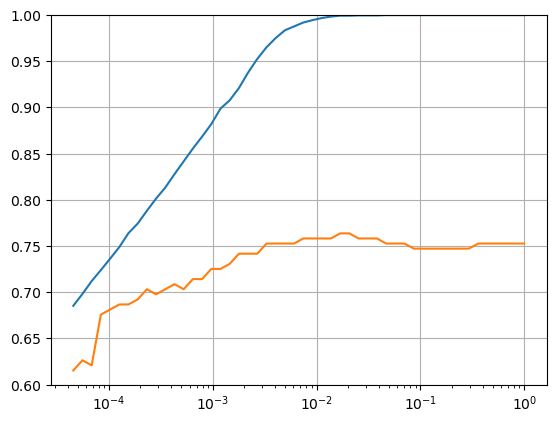

In [9]:
plt.xscale('log')
plt.plot(C_values,train_accuracies)
plt.plot(C_values,test_accuracies)
plt.ylim((0.6,1.0))
plt.grid()
plt.show()

In [10]:
emb = classifiers.Classifier(input_X = embeddings,
                             input_y = labels,
                             ordered_labels = frog_bird_labels)

emb.t_t_split()

In [11]:
emb.log_reg(CV = False)
print("---------------------")

emb.log_reg(CV = True)
print("---------------------")

The Logistic Regression test accuracy was 0.9178832116788321
The Logistic Regression train accuracy was 1.0
You can load and save the confusion matrix from the pickled dictionary under the key 'log_reg_mat'
---------------------
CV Split: 0
CV Split: 1
CV Split: 2
CV Split: 3
CV Split: 4
Elapsed Time: 3.3230295181274414
The highest CV Logistic Regression test accuracy was 0.95
The highest CV Logistic Regression train accuracy was 1.0
---------------------


##### Try Log Reg with some regularization based on the chart above:

In [32]:
emb.log_reg(CV = False,
            penalty='l2',
            C_val=0.002)
print("---------------------")

emb.log_reg(CV = True,
            penalty='l2',
            C_val=0.002)
print("---------------------")

The Logistic Regression test accuracy was 0.8248175182481752
The Logistic Regression train accuracy was 0.9251612903225807
You can load and save the confusion matrix from the pickled dictionary under the key 'log_reg_mat'
---------------------
CV Split: 0
CV Split: 1
CV Split: 2
CV Split: 3
CV Split: 4
Elapsed Time: 9.608655214309692
The highest CV Logistic Regression test accuracy was 0.85
The highest CV Logistic Regression train accuracy was 0.9266129032258065
---------------------


In [13]:
emb.svm(CV = False)
print("---------------------")
emb.svm(CV = True)
print("---------------------")

The SVM test accuracy was 0.8978102189781022
The SVM train accuracy was 0.9854838709677419
You can load and save the confusion matrix from the pickled dictionary under the key 'svm_mat'
---------------------
CV Split: 0
CV Split: 1
CV Split: 2
CV Split: 3
CV Split: 4
Elapsed Time: 27.57935357093811
The highest CV SVM test accuracy was 0.9274193548387096
The highest CV SVM train accuracy was 0.9822580645161291
---------------------


In [14]:
emb.knn(CV = False,
        n_neighbors = 1)
print("---------------------")

emb.knn(CV = True,
        max_n_neighbors = 20)
print("---------------------")

The KNN test accuracy was 0.9635036496350365
The KNN train accuracy was 1.0
You can load and save the confusion matrix from the pickled dictionary under the key 'knn_mat'
---------------------
CV Split: 0
CV Split: 1
CV Split: 2
CV Split: 3
CV Split: 4
Elapsed Time: 16.074874877929688
The k with the highest AVG CV Accuracy was k = 1
The highest CV KNN test accuracy was 0.6951612903225806
The corresponding CV KNN train accuracy was 0.7434677419354839
---------------------


In [15]:
emb.save_statistics('/home/birdsong/classifier_stats/emb_stats')
classifiers.save_object_to_pickle(emb, '/home/birdsong/classifier_stats/emb')

In [16]:
np.savetxt('/home/birdsong/classifier_stats/emb_log_reg_CM_mat.csv', emb.log_reg_mat, delimiter = ',')
np.savetxt('/home/birdsong/classifier_stats/emb_svm_CM_mat.csv', emb.svm_mat, delimiter = ',')
np.savetxt('/home/birdsong/classifier_stats/emb_knn_CM_mat.csv', emb.knn_mat, delimiter = ',')

#### These models seem to be overfitting a fair bit with the default train test split, so let's try out the same process, but load in our custom train test split from above that respects the data augmentation.

In [28]:
emb_aug = classifiers.Classifier(input_X = embeddings,
                             input_y = labels,
                             ordered_labels = frog_bird_labels)

In [30]:
emb_aug.X_train = X_train
emb_aug.X_test = X_test
emb_aug.y_train = y_train
emb_aug.y_test = y_test

In [34]:
emb_aug.log_reg(CV = False,
            penalty='l2',
            C_val=0.001)
print("---------------------")

emb_aug.log_reg(CV = True,
            penalty='l2',
            C_val=0.001)
print("---------------------")

The Logistic Regression test accuracy was 0.7252747252747253
The Logistic Regression train accuracy was 0.8862024500322373
You can load and save the confusion matrix from the pickled dictionary under the key 'log_reg_mat'
---------------------
CV Split: 0
CV Split: 1
CV Split: 2
CV Split: 3
CV Split: 4
Elapsed Time: 8.69735598564148
The highest CV Logistic Regression test accuracy was 0.8209677419354838
The highest CV Logistic Regression train accuracy was 0.8803384367445608
---------------------


In [35]:
emb_aug.svm(CV = False)
print("---------------------")
emb_aug.svm(CV = True)
print("---------------------")

The SVM test accuracy was 0.7252747252747253
The SVM train accuracy was 0.9887169568020632
You can load and save the confusion matrix from the pickled dictionary under the key 'svm_mat'
---------------------
CV Split: 0
CV Split: 1
CV Split: 2
CV Split: 3
CV Split: 4
Elapsed Time: 27.822956323623657
The highest CV SVM test accuracy was 0.9338709677419355
The highest CV SVM train accuracy was 0.9866989117291415
---------------------


In [36]:
emb_aug.knn(CV = False,
        n_neighbors = 1)
print("---------------------")

emb_aug.knn(CV = True,
        max_n_neighbors = 20)
print("---------------------")

The KNN test accuracy was 0.6153846153846154
The KNN train accuracy was 1.0
You can load and save the confusion matrix from the pickled dictionary under the key 'knn_mat'
---------------------
CV Split: 0
CV Split: 1
CV Split: 2
CV Split: 3
CV Split: 4
Elapsed Time: 40.95282173156738
The k with the highest AVG CV Accuracy was k = 1
The highest CV KNN test accuracy was 0.6921391096566412
The corresponding CV KNN train accuracy was 0.7405691799172502
---------------------


In [37]:
emb_aug.save_statistics('/home/birdsong/classifier_stats/emb_aug_stats')
classifiers.save_object_to_pickle(emb_aug, '/home/birdsong/classifier_stats/emb_aug')

In [38]:
np.savetxt('/home/birdsong/classifier_stats/emb_aug_log_reg_CM_mat.csv', emb_aug.log_reg_mat, delimiter = ',')
np.savetxt('/home/birdsong/classifier_stats/emb_aug_svm_CM_mat.csv', emb_aug.svm_mat, delimiter = ',')
np.savetxt('/home/birdsong/classifier_stats/emb_aug_knn_CM_mat.csv', emb_aug.knn_mat, delimiter = ',')